In [3]:
# data
import pandas as pd
import numpy as np
# Keras with TensorFlow backend 
import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam
# some ML libraries
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
# image plotting
import seaborn as sns
%pylab inline

Using TensorFlow backend.
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


C:\Users\Asus\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'add', 'maximum', 'multiply', 'dot', 'average', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
train = pd.read_csv("./data/RegularSeasonDetailedResults.csv")
print(train.shape)
train.head()

(71241, 34)


,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [3]:
train.Season.value_counts()

2016    5369
2014    5362
2015    5354
2013    5320
2010    5263
2012    5253
2009    5249
2011    5246
2008    5163
2007    5043
2006    4757
2005    4675
2003    4616
2004    4571
Name: Season, dtype: int64

In [26]:
train_win_res = train.groupby(['Season', 'Wteam']).count()[["Wscore", 'Lscore']]
train_win_res["Lscore"] = train.groupby(['Season', 'Lteam']).count()["Wscore"]
train_win_res["Winrate"] = train_win_res.Wscore/(train_win_res.Wscore+train_win_res.Lscore)
train_win_res["Count"] = train_win_res.Wscore+train_win_res.Lscore
train_win_res.sample(5)

,,Wscore,Lscore,Winrate,Count
Season,Wteam,,,,
2008,1233,12,20.0,0.375000,32.0
2004,1332,15,12.0,0.555556,27.0
2005,1186,7,20.0,0.259259,27.0
2015,1265,7,25.0,0.218750,32.0
2012,1162,13,15.0,0.464286,28.0


In [6]:
sample_team = [1180,1347,1435,1156,1141,1398,1207,1336,1412]
years = [2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]

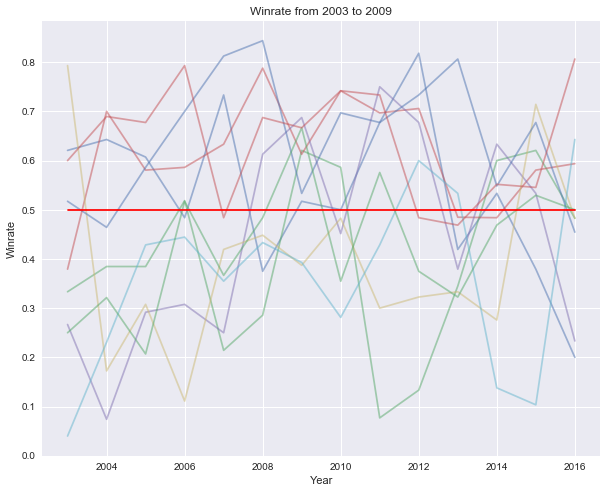

In [10]:
pylab.figure(figsize=(10,8))
for i in sample_team:
    try: 
        pylab.plot(years, [train_win_res.loc[y,i]['Winrate'] for y in years], alpha=0.5)
    except Exception as e:
        pass
        
pylab.title("Winrate from 2003 to 2009")
pylab.ylabel("Winrate")
pylab.xlabel("Year")
pylab.plot([2003,2016], [0.5,0.5], c = "red")

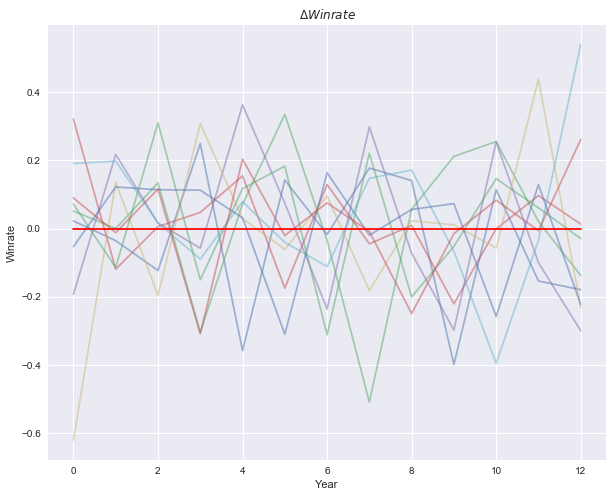

In [12]:
pylab.figure(figsize=(10,8))
for i in sample_team:
    try: 
        pylab.plot([train_win_res.loc[2004+y,i]['Winrate']-train_win_res.loc[2003+y,i]['Winrate'] \
                    for y in range(len(years)-1)], alpha=0.5)
    except Exception as e:
        pass
        
pylab.title("$\Delta Winrate$")
pylab.ylabel("Winrate")
pylab.xlabel("Year")
pylab.plot([0,0,0,0,0,0,0,0,0,0,0,0,0], c = "red")

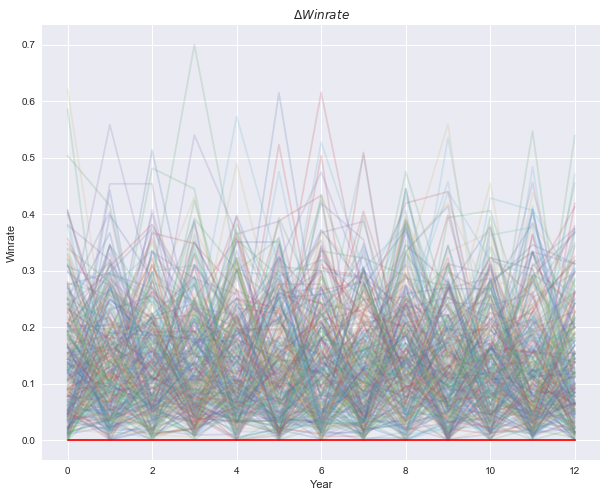

In [21]:
pylab.figure(figsize=(10,8))
for i in train.Wteam.unique():
    try: 
        pylab.plot([abs(train_win_res.loc[2004+y,i]['Winrate']-train_win_res.loc[2003+y,i]['Winrate']) \
                    for y in range(len(years)-1)], alpha=0.2)
    except Exception as e:
        pass
        
pylab.title("$\Delta Winrate$")
pylab.ylabel("Winrate")
pylab.xlabel("Year")
pylab.plot([0,0,0,0,0,0,0,0,0,0,0,0,0], c = "red")

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in less


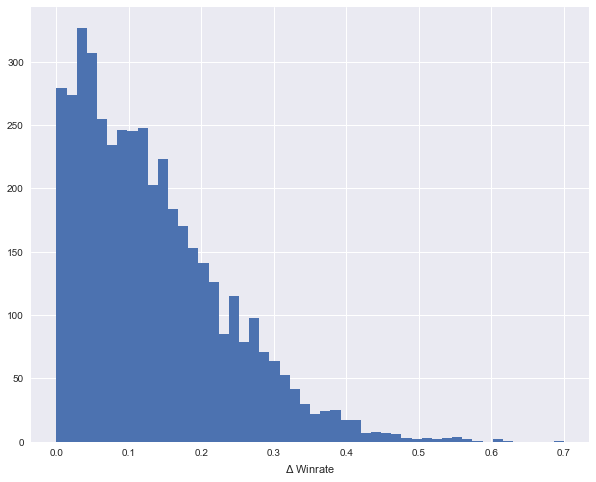

In [32]:
pylab.figure(figsize=(10,8))
data = []
for i in train.Wteam.unique():
    for y in range(len(years)-1):
        try: 
            data.append(abs(train_win_res.loc[2004+y,i]['Winrate']-train_win_res.loc[2003+y,i]['Winrate']))
        except Exception as e:
            pass
data = np.array(data)

pylab.hist(data[data<2], bins = 50)
pylab.xlabel("$\Delta$ Winrate")

In [33]:
col = train.columns
wcol = [i for i in col if (i[0]=="W" and i!="Wloc" and i!="Wteam")]
lcol = [i for i in col if (i[0]=="L" and i!="Lteam")]
len(wcol)==len(lcol)
X = train.groupby("Wteam").sum()[wcol]
X += train.groupby("Lteam").sum()[lcol].as_matrix()
X = X/np.hstack([train.groupby('Wteam').count()["Lteam"].as_matrix().reshape(-1,1) for i in range(14)])
teams = X.reset_index()
y = np.random.randint(0,2,train.shape[0])
X = train[["Wteam","Lteam"]]
X["Wteam"] = train.Wteam*y+train.Lteam*(1-y)
X["Lteam"] = train.Lteam*y+train.Wteam*(1-y)
X = pd.merge(X, teams, left_on = "Wteam", right_on="Wteam").drop("Wteam", 1)
X = pd.merge(X, teams, left_on = "Lteam", right_on="Wteam").drop(["Wteam", "Lteam"], 1)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
models = {"XGBoost" : xgb.XGBClassifier(), 
          "LogReg" : LogisticRegression(),
          "RandomForest" : RandomForestClassifier()}

In [36]:
scores = {i : -np.mean(cross_val_score(models[i], X, y, scoring = 'neg_log_loss')) for i in models}
for i in scores:
    print(i, scores[i])

XGBoost 0.702355591057
LogReg 0.693339204183
RandomForest 0.882730941402


In [37]:
data = pd.read_csv("./data/RegularSeasonCompactResults.csv")
data.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [38]:
teams = list(data.Wteam.unique())
start_year = 2000
stop_year = 2015

In [39]:
sm = np.zeros((len(data.Wteam.value_counts()), len(data.Wteam.value_counts())))
ngames = np.zeros((len(data.Wteam.value_counts()), len(data.Wteam.value_counts())))
for wteam, lteam, wscore, lscore in zip(data.Wteam[(data.Season <= stop_year) * (data.Season > start_year)], 
                                        data.Lteam[(data.Season <= stop_year) * (data.Season > start_year)], 
                                        data.Wscore[(data.Season <= stop_year) * (data.Season > start_year)], 
                                        data.Lscore[(data.Season <= stop_year) * (data.Season > start_year)]):
    sm[teams.index(wteam), teams.index(lteam)] += 1
    sm[teams.index(lteam), teams.index(wteam)] -= 1
    ngames[teams.index(wteam), teams.index(lteam)] += 1
    ngames[teams.index(lteam), teams.index(wteam)] += 1

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


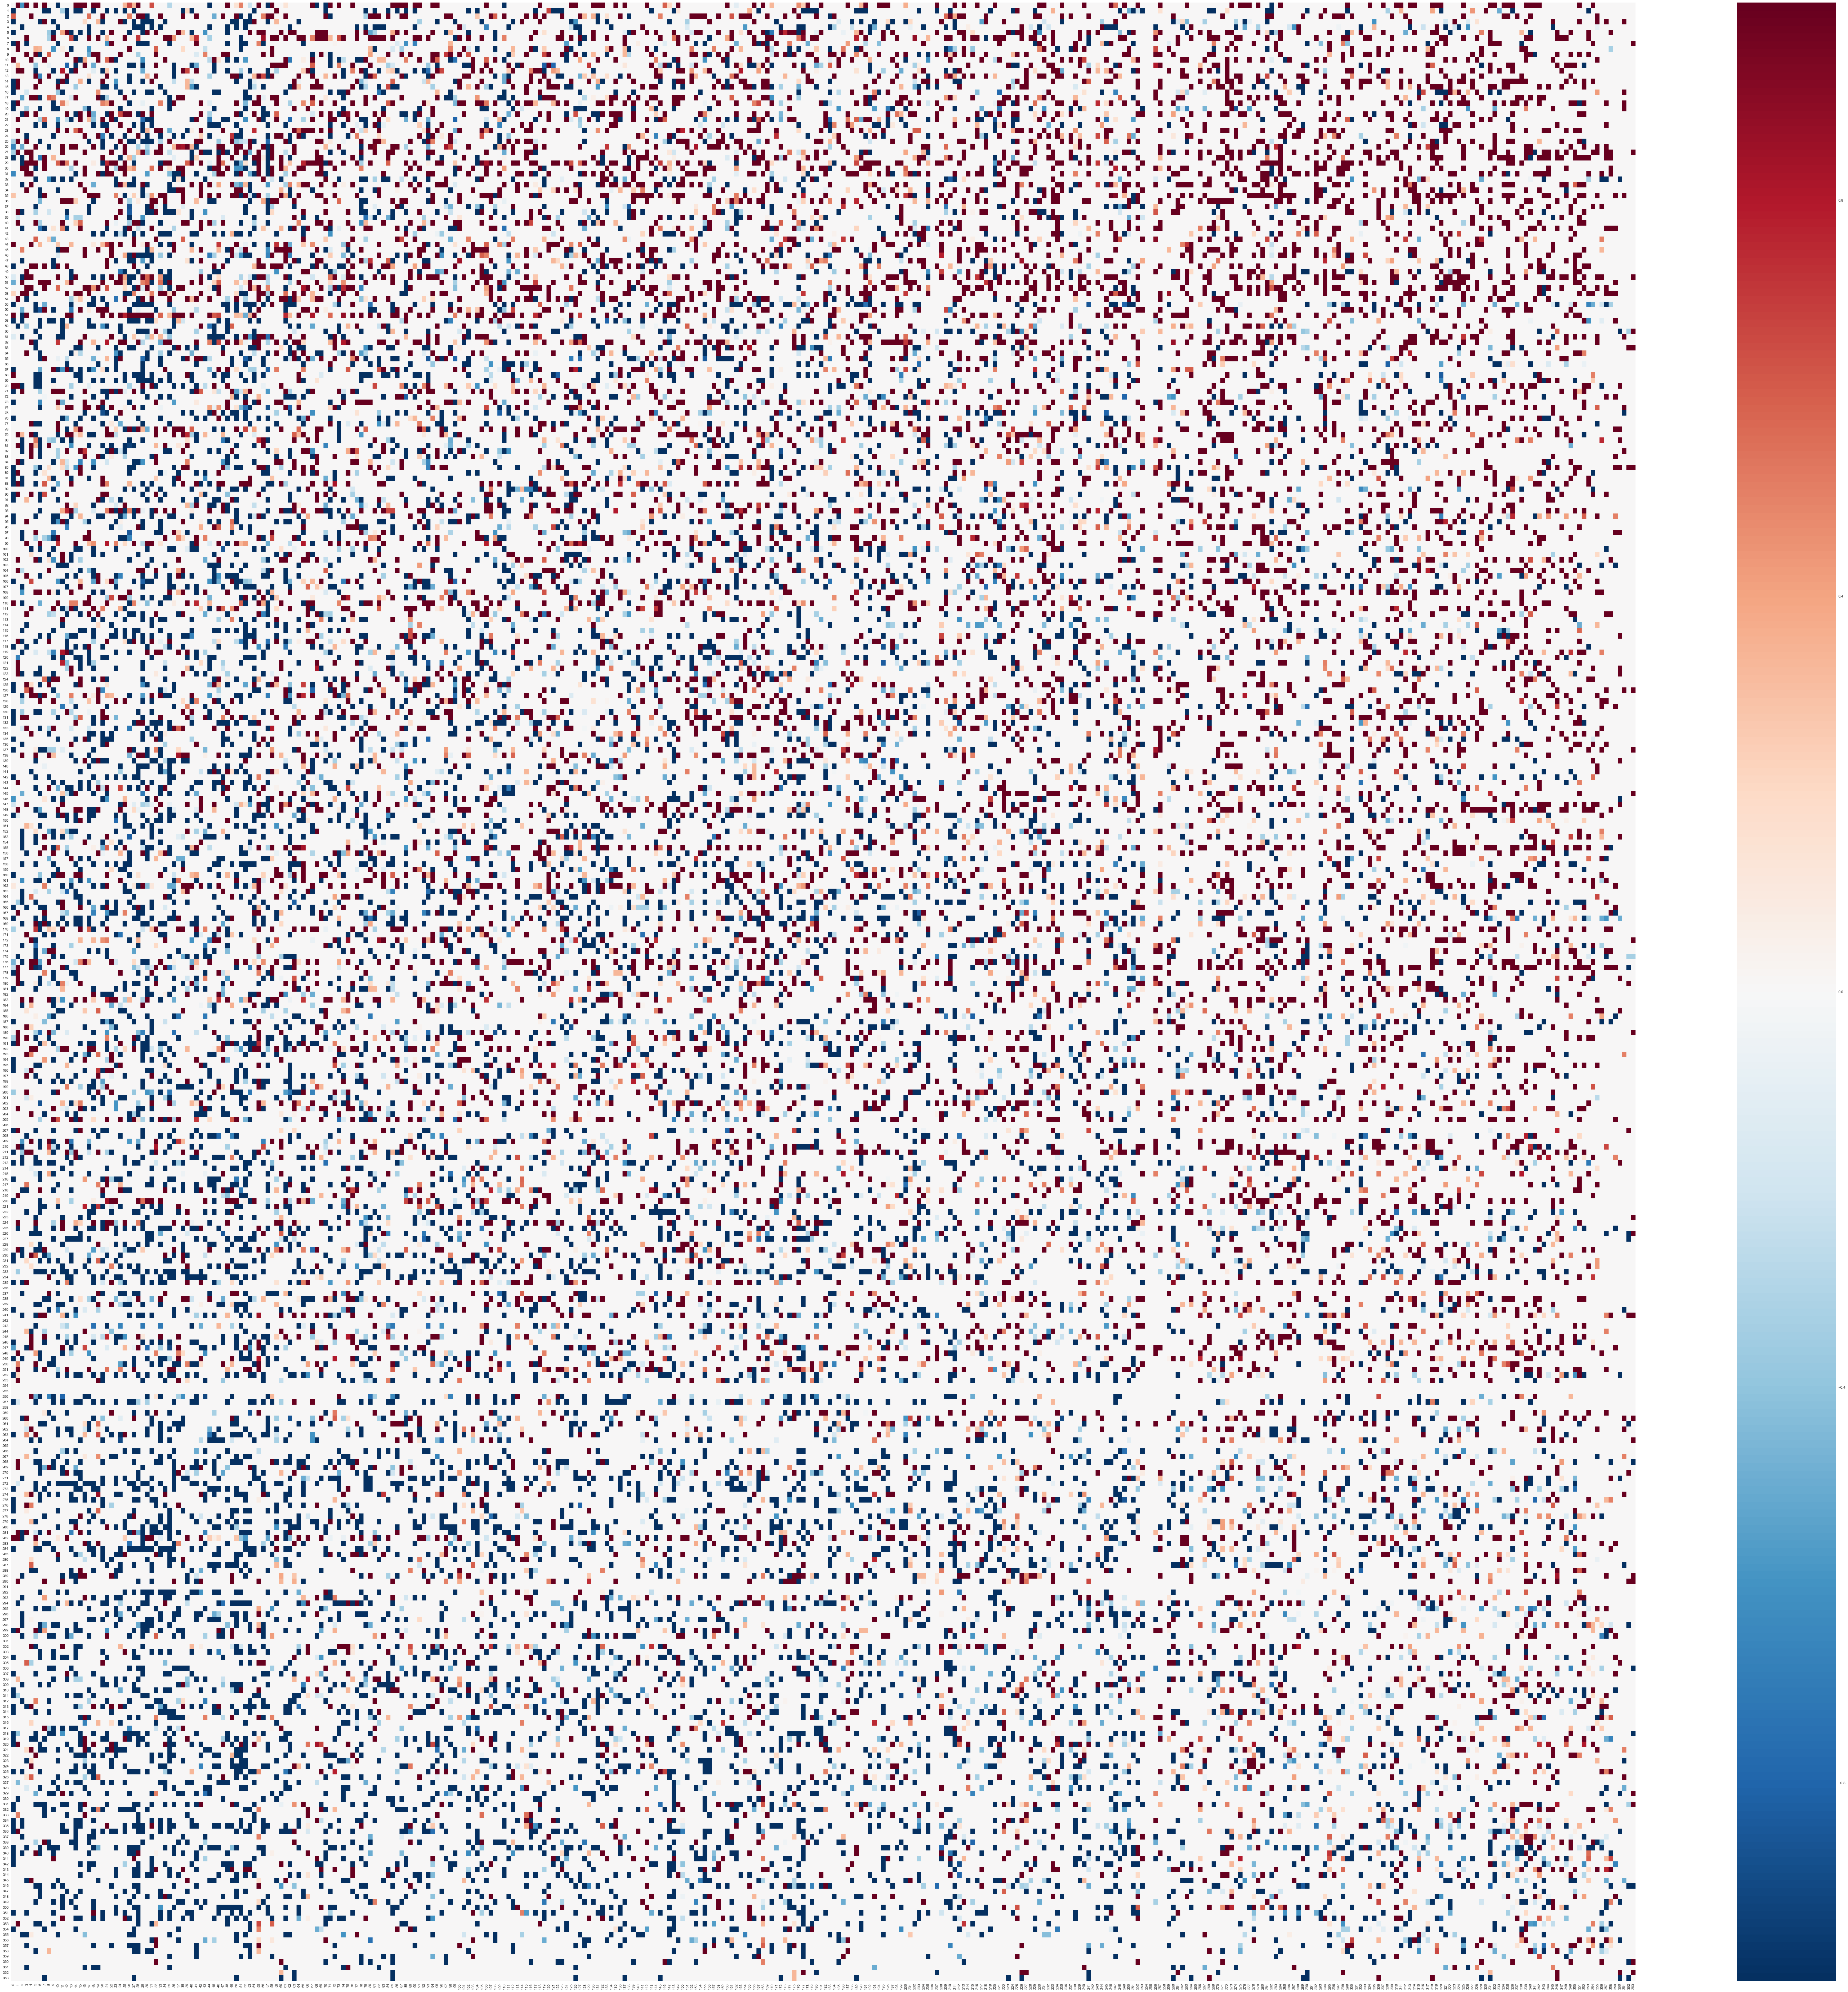

In [40]:
dense_sm = sm/ngames
dense_sm[np.isnan(dense_sm)] = 0
pylab.figure(figsize=(100,100))
sns.heatmap(dense_sm)

In [41]:
train = np.vstack([data[["Wteam", "Lteam"]][(data.Season <= stop_year) * (data.Season > start_year)].as_matrix(), 
                   data[["Lteam", "Wteam"]][(data.Season <= stop_year) * (data.Season > start_year)].as_matrix()])
y = np.hstack([np.ones(sum((data.Season <= stop_year) * (data.Season > start_year))), 
               np.zeros(sum((data.Season <= stop_year) * (data.Season > start_year)))])
test = np.vstack([data[["Wteam", "Lteam"]][data.Season > stop_year].as_matrix(), 
                   data[["Lteam", "Wteam"]][data.Season > stop_year].as_matrix()])
y_test = np.hstack([np.ones(sum((data.Season > stop_year))), np.zeros(sum((data.Season > stop_year)))])
idx = np.vectorize(lambda x: teams.index(x))

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [44]:
train_dataset = np.hstack([dense_sm[[idx(train[:,0])]], dense_sm[[idx(train[:,1])]]])
test_dataset = np.hstack([dense_sm[[idx(test[:,0])]], dense_sm[[idx(test[:,1])]]])

In [47]:
%%time
lr = LogisticRegression(C = 10)
lr.fit(train_dataset, y)

Wall time: 2min 3s


In [48]:
log_loss(y_test, lr.predict_proba(test_dataset))

0.6120607924003173

In [4]:
data = pd.read_csv("./data/RegularSeasonCompactResults.csv")
teams_data = pd.read_csv("tdf_new16.csv")
start_year = 2000
stop_year = 2015

In [5]:
idx = np.vectorize(lambda x: teams.index(x))
teams = list(teams_data["index"])
teams_data = teams_data.drop(["index"], 1)

In [6]:
train = np.vstack([data[["Wteam", "Lteam"]][(data.Season <= stop_year) * (data.Season > start_year)].as_matrix(), 
                   data[["Lteam", "Wteam"]][(data.Season <= stop_year) * (data.Season > start_year)].as_matrix()])
y = np.hstack([np.ones(sum((data.Season <= stop_year) * (data.Season > start_year))), 
               np.zeros(sum((data.Season <= stop_year) * (data.Season > start_year)))])
train_dataset = np.hstack([teams_data.as_matrix()[[idx(train[:,0])]], 
                           teams_data.as_matrix()[[idx(train[:,1])]]])
test = np.vstack([data[["Wteam", "Lteam"]][data.Season > stop_year].as_matrix(), 
                   data[["Lteam", "Wteam"]][data.Season > stop_year].as_matrix()])
y_test = np.hstack([np.ones(sum((data.Season > stop_year))), np.zeros(sum((data.Season > stop_year)))])
test_dataset = np.hstack([teams_data.as_matrix()[[idx(test[:,0])]],
                          teams_data.as_matrix()[[idx(test[:,1])]]])

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [7]:
model = Sequential()
model.add(Dense(512, input_dim=798, init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512,  init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(256,  init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(32, init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1, init='uniform', activation='sigmoid'))

C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=798, activation="relu", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="sigmoid", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="sigmoid", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               409088    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
__________

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=["accuracy","binary_crossentropy"])

In [10]:
history = model.fit(train_dataset, y,
                    batch_size=256, epochs=80,
                    verbose=0, validation_data=(test_dataset, y_test))

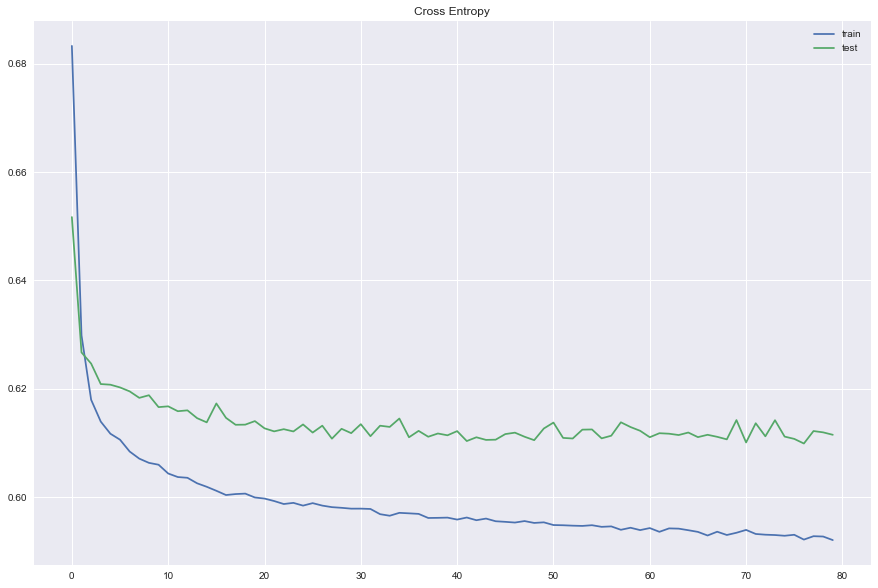

In [11]:
pylab.figure(figsize=(15,10))
pylab.plot(history.history['binary_crossentropy'], label = "train")
pylab.plot(history.history['val_binary_crossentropy'], label = "test")
pylab.title("Cross Entropy")
pylab.legend()